In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [3]:
import re
import nltk

In [4]:
data = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [7]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
data.sentiment = [0 if i=="negative" else 1 for i in data.sentiment.values]

In [9]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

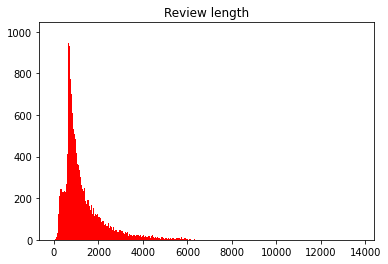

In [10]:
import matplotlib.pyplot as plt

review_len = data.review.str.len()
plt.hist(review_len, color="red", bins=1000)
plt.title("Review length")
plt.show()

In [11]:
def lower_text(text):
    text = " ".join(i.lower() for i in text.split())
    return text

In [12]:
from bs4 import BeautifulSoup

def remove_noise(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub("\[[^]]*\]", "", text)
    return text

In [13]:
import string 

def remove_punc(text):
    tokens = text.split()
    re_punc = re.compile("[%s]"%re.escape(string.punctuation))
    tokens = [re_punc.sub("", w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    text = " ".join(tokens)
    
    return text

In [14]:
def preprocess_data(text):
    text = lower_text(text)
    text = remove_noise(text)
    text = remove_punc(text)
    
    return text

data.review = data.review.apply(preprocess_data)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


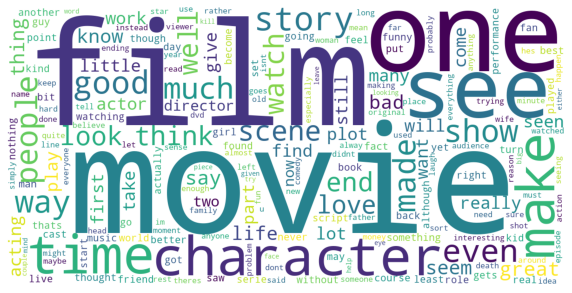

In [15]:
import wordcloud

text = " ".join(i for i in data.review)

wc = wordcloud.WordCloud(width=1200, height=600, background_color="white")
wc.generate(text)

plt.figure(figsize=[10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show()

In [16]:
from nltk.corpus import stopwords
nltk.download("stopwrds")

stop_words = set(stopwords.words("english"))

def create_corpus():
    corpus = []
    for x in data.review:
        for i in x.split():
            if i not in stop_words:           
                corpus.append(i)
    return corpus

corpus = create_corpus()

[nltk_data] Error loading stopwrds: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


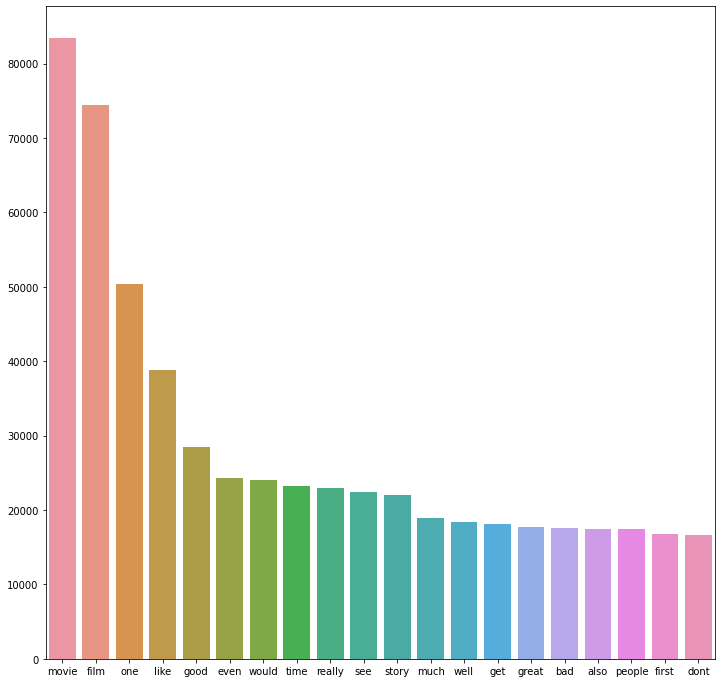

In [17]:
from collections import Counter
import seaborn as sns

counter = Counter(corpus)
most_words = counter.most_common()

words = []
counts = []

for word, count in most_words[:20]:
    if word not in stop_words:
        words.append(word)
        counts.append(count)

plt.figure(figsize=(12,12))
sns.barplot(x=words, y=counts)
plt.show()

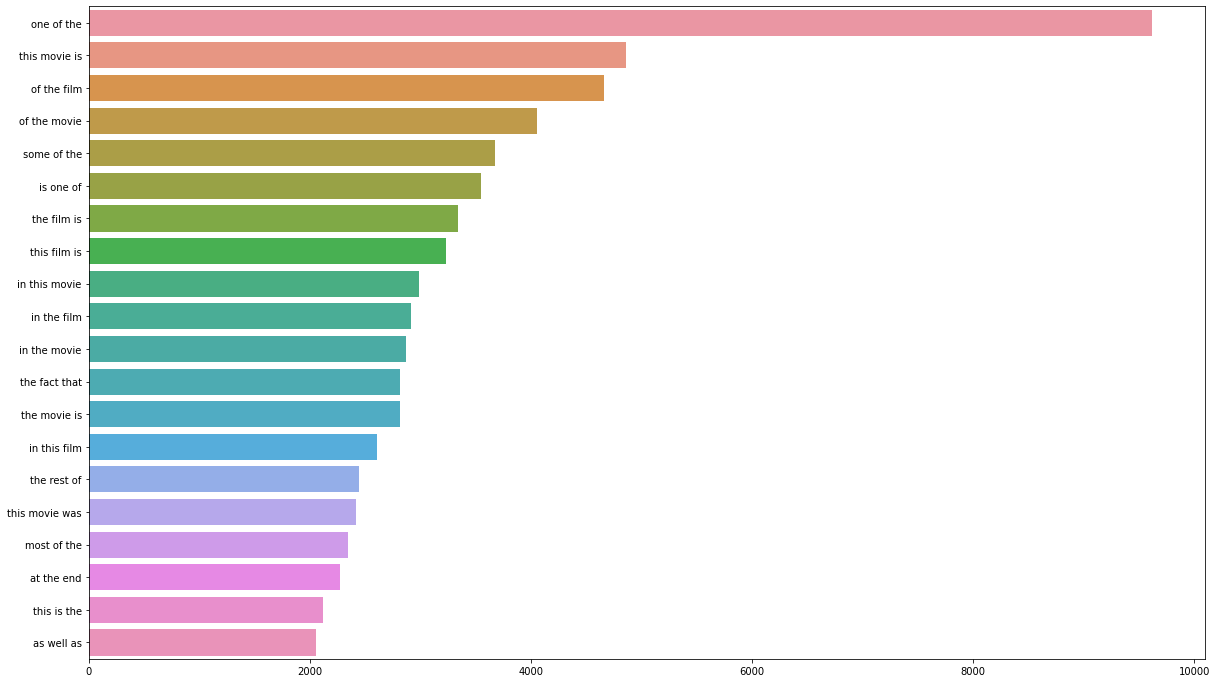

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def most_matches(corpus):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

plt.figure(figsize=(20, 12))
biagram = most_matches(data.review)[:20]
x, y = map(list, zip(*biagram))
sns.barplot(x=y, y=x)
plt.show()


In [19]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data.review, data.sentiment, test_size=.25)


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<00V>")
tokenizer.fit_on_texts(train_X)

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

train_X = pad_sequences(train_X, maxlen=100, padding="pre", truncating= 'post')
val_X = pad_sequences(val_X, maxlen=100, padding="pre", truncating= 'post')

print(train_X.shape)

(37500, 100)


In [21]:
from tensorflow.keras.layers import Dropout, Dense, Conv1D, Bidirectional, LSTM, Embedding
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(Dropout(.4))
model.add(Conv1D(256, 7, activation="relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dropout(.4))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop",
             metrics=["accuracy"], loss="binary_crossentropy")

model.fit(train_X, train_y, batch_size=64,
         epochs=5, validation_data=(val_X, val_y))

2022-10-30 23:10:05.594196: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-30 23:10:07.177309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
586/586 [==============================] - 329s 544ms/step - loss: 0.5019 - accuracy: 0.7600 - val_loss: 0.4180 - val_accuracy: 0.8201
Epoch 2/5
586/586 [==============================] - 312s 533ms/step - loss: 0.3885 - accuracy: 0.8351 - val_loss: 0.3757 - val_accuracy: 0.8363
Epoch 3/5
586/586 [==============================] - 312s 532ms/step - loss: 0.3523 - accuracy: 0.8533 - val_loss: 0.3679 - val_accuracy: 0.8386
Epoch 4/5
586/586 [==============================] - 313s 534ms/step - loss: 0.3269 - accuracy: 0.8643 - val_loss: 0.3804 - val_accuracy: 0.8376
Epoch 5/5
586/586 [==============================] - 317s 540ms/step - loss: 0.3062 - accuracy: 0.8753 - val_loss: 0.3818 - val_accuracy: 0.8358


In [1]:
review_list = ['''excited  , there are some peroids were boring so the the total is  good ''', "The first scene of the movie grabbed me at the first glance and took me to another world.", 
                "I don't like the way how the director decided to shoot this scene on that castle.", "I found the girl on the movie very hot and breath-taking."]

for text in review_list:
    text_seq = tokenizer.texts_to_sequences([preprocess_data(text)])
    text_seq = pad_sequences(text_seq, maxlen=200)

    pred = "Positive" if round(model.predict(text_seq)[0][0])==1 else "Negative"
    
    print("Review: {}".format(text))
    print("Sentiment: {}".format(pred))
    print()
    
    

NameError: name 'tokenizer' is not defined